### Getting the (3D) dataset ready

In [3]:
import os
from glob import glob
import nibabel as nib # for working with neuroimaging data in NIfTI format !!

import numpy as np # for file pattern matching
import matplotlib.pyplot as plt

import torch

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [6]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

#### ***Preprocessing steps:***
Iterates over each image in the dataset:
1. Load the **image** in each MRI modality (apart from native T1 which is not informative) and scale its intensity values to the range [0, 1] using Min-Max scaling to ensure consistency across modalities and avoid issues like numerical instability or bias toward features with larger numerical ranges.
2. Combine the three MRI modalities (T2, T1ce, FLAIR) into a single 4D array of shape 240x240x155x3 creating a multi-channel 3D volume.
3. The segmentation **mask** is also loaded and adjusted:
- mask array values are converted from float64 (as loaded using nibabel library) to uint8 since we want integer labels;
- at this point the unique values in the mask are [0,1,2,4] and we need to replace label 4 with label 3.
4. Crop the volumes and masks to remove non-informative background and to reduce computational complexity.
5. Check if the mask contains at least 1% useful volume with labels other than 0 and if this condition is met, convert the masks to categorical format (using 1-hot encoding) resulting in an array of size 128x128x128x4, otherwise the current sample is discarded from the dataset.
6. Save the processed volume and mask as numpy arrays.

In [ ]:
t2_list = sorted(glob('BraTS2021_Training_Data/*/*t2.nii.gz'))
# glob returns a list of paths matching the given pattern != from os.listdir that does not return entire paths
t1ce_list = sorted(glob('BraTS2021_Training_Data/*/*t1ce.nii.gz'))

flair_list = sorted(glob('BraTS2021_Training_Data/*/*flair.nii.gz'))

mask_list = sorted(glob('BraTS2021_Training_Data/*/*seg.nii.gz'))

In [9]:
for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    # Crop to a size to be divisible by 64 (to later facilitate patch extraction)
    #temp_combined_images=temp_combined_images[24:216, 24:216, 13:141]
    #temp_mask = temp_mask[24:216, 24:216, 13:141]
    #           OR
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save")
        temp_mask_one_hot = torch.zeros((*temp_mask.shape, 4), dtype=torch.float32)
        temp_mask_one_hot.scatter_(3, torch.unsqueeze(torch.tensor(temp_mask, dtype=torch.int64), 3), 1)

        output_dir = 'BraTS2021_TrainingData/input_data_3channels'
        image_dir = os.path.join(output_dir, 'images')
        mask_dir = os.path.join(output_dir, 'masks')
        os.makedirs(image_dir, exist_ok=True)
        os.makedirs(mask_dir, exist_ok=True)
        np.save('BraTS2021_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('BraTS2021_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask_one_hot)
        
    else:
        print("Useless") 


################################################################
# splitting the data folder 80% train - 20% validation

import splitfolders  # or import split_folders

input_folder = 'BraTS2021_TrainingData/input_data_3channels/'
output_folder = 'BraTS2021_TrainingData/input_data_128/'

# Split with a ratio.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None) # default values

Now preparing image and masks number:  170
Save Me
Now preparing image and masks number:  171
I am useless
Now preparing image and masks number:  172
Save Me
Now preparing image and masks number:  173
Save Me
Now preparing image and masks number:  174
Save Me
Now preparing image and masks number:  175
Save Me
Now preparing image and masks number:  176
Save Me
Now preparing image and masks number:  177
Save Me
Now preparing image and masks number:  178
Save Me
Now preparing image and masks number:  179
Save Me
Now preparing image and masks number:  180
Save Me
Now preparing image and masks number:  181
Save Me
Now preparing image and masks number:  182
Save Me
Now preparing image and masks number:  183
Save Me
Now preparing image and masks number:  184
Save Me
Now preparing image and masks number:  185
Save Me
Now preparing image and masks number:  186
Save Me


Copying files: 32 files [00:01, 20.40 files/s]


### NOW we try the previous pre-processing pipeline on a single image-mask pair to better visualize it

- load **image** and scale its intensity values to the range [0, 1] using Min-Max scaling
- replace label 4 with label 3 in **segmentation mask**

In [35]:
temp_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00214/BraTS2021_00214_t2.nii.gz').get_fdata()
temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

temp_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00214/BraTS2021_00214_t1ce.nii.gz').get_fdata()
temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

temp_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00214/BraTS2021_00214_flair.nii.gz').get_fdata()
temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
    
temp_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00214/BraTS2021_00214_seg.nii.gz').get_fdata()
temp_mask=temp_mask.astype(np.uint8)

temp_mask[temp_mask==4]=3  #Reassign mask values 4 to 3

visualizing the modalities and the corresponding mask

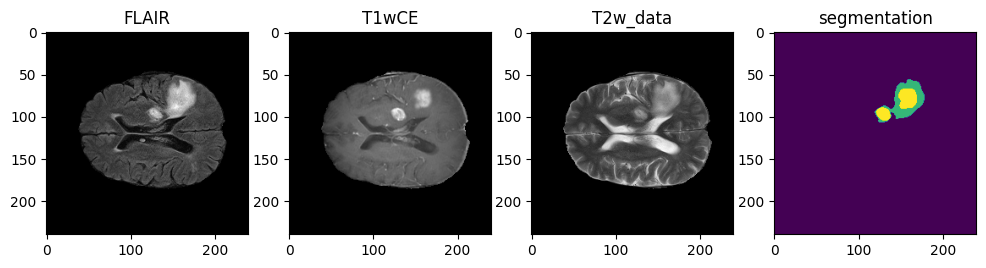

In [36]:
plt.figure(figsize=(12,6))

slice = 80

plt.subplot(141)
plt.title('FLAIR')
plt.imshow(temp_image_flair[:,:,slice], cmap='gray') # we are selecting slice 70 (in total there are 155 per volume)
plt.subplot(142)
plt.title('T1wCE')
plt.imshow(temp_image_t1ce[:,:,slice], cmap='gray')
plt.subplot(143)
plt.title('T2w_data')
plt.imshow(temp_image_t2[:,:,slice], cmap='gray')
plt.subplot(144)
plt.title('segmentation')
plt.imshow(temp_mask[:,:,slice])

- combine three MRI modalities (T2, T1ce, FLAIR) into a single 4D array

In [37]:
temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
temp_combined_images.shape

(240, 240, 155, 3)

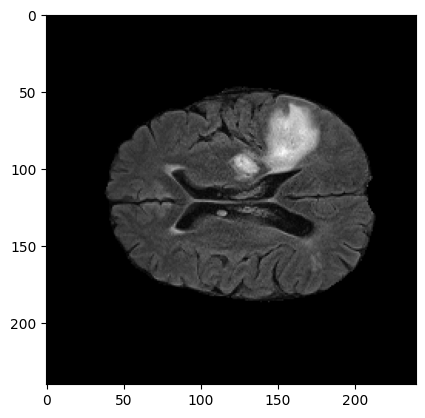

In [38]:
plt.imshow(temp_combined_images[:,:,slice,0], cmap='gray') # we are plotting the FLAIR image since we used the index 0

- crops the images and masks


In [39]:
temp_combined_images = temp_combined_images[56:184, 56:184, 13:141] # crop to 128 x 128 x 128 x 3
temp_mask = temp_mask[56:184, 56:184, 13:141]

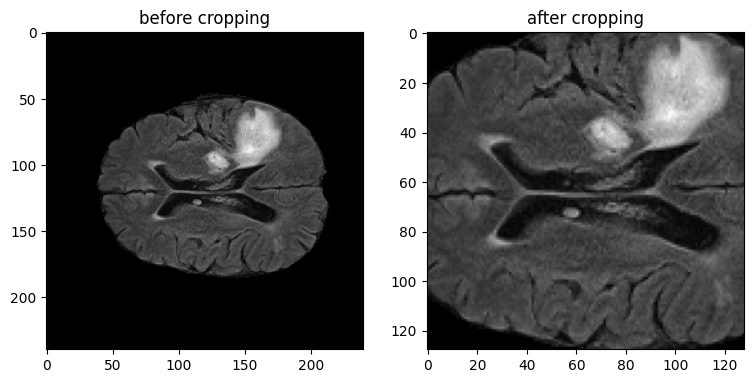

In [40]:
temp_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00214/BraTS2021_00214_flair.nii.gz').get_fdata()
temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
temp_image_flair_2=temp_image_flair[56:184, 56:184, 13:141]

temp_mask[temp_mask==4]=3

plt.figure(figsize=(9,5))

plt.subplot(121)
plt.title('before cropping')
plt.imshow(temp_image_flair[:,:,80], cmap='gray') # we are selecting slice 80 (in total there are 155 per volume)
plt.subplot(122)
plt.title('after cropping')
plt.imshow(temp_image_flair_2[:,:,67], cmap = 'gray')

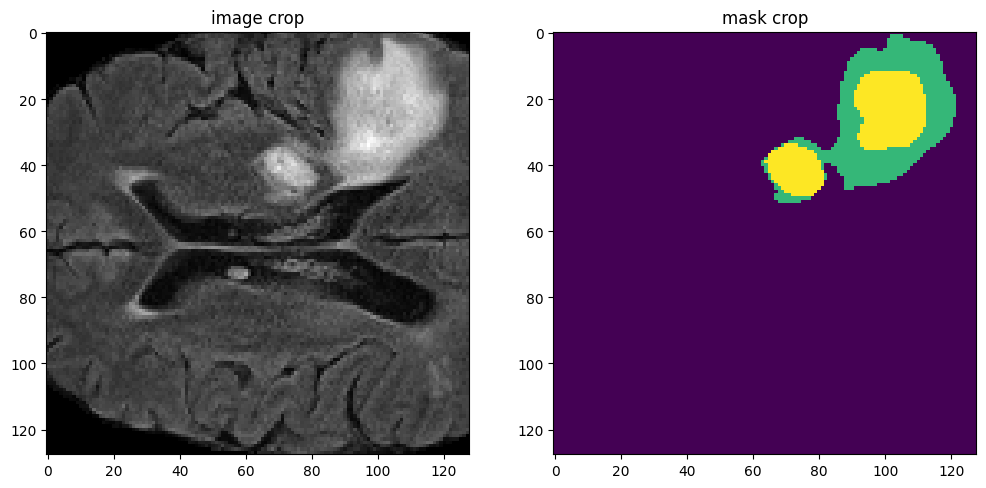

In [44]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('image crop')
plt.imshow(temp_combined_images[:,:,67,0], cmap='gray')
plt.subplot(122)
plt.title('mask crop')
plt.imshow(temp_mask[:,:,67])


- checks if the **mask** contains at least 1% useful volume with labels other than 0 and if this condition is met, it converts the masks to categorical format
- saves the image and mask as numpy arrays

such that when I load them again in my code I can treat them as before 

In [45]:
val, counts = np.unique(temp_mask, return_counts=True)  # find the unique elements of an array and count them

In [46]:
print(temp_mask.shape)

(128, 128, 128)


In [ ]:
if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
    print("Save")
    temp_mask_one_hot = torch.zeros((*temp_mask.shape, 4), dtype=torch.float32)
    temp_mask_one_hot.scatter_(3, torch.unsqueeze(torch.tensor(temp_mask, dtype=torch.int64), 3), 1)

    output_dir = 'BraTS2021_TrainingDataTry/input_data_3channels'
    image_dir = os.path.join(output_dir, 'images')
    mask_dir = os.path.join(output_dir, 'masks')
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)
    np.save('BraTS2021_TrainingDataTry/input_data_3channels/images/image_'+str('00211')+'.npy', temp_combined_images)
    np.save('BraTS2021_TrainingDataTry/input_data_3channels/masks/mask_'+str('00211')+'.npy', temp_mask_one_hot)
    
else:
    print("Useless") 

In [ ]:
my_img=np.load('BraTS2021_TrainingDataTry/input_data_3channels/images/image_00211.npy')
my_mask=np.load('BraTS2021_TrainingDataTry/input_data_3channels/masks/mask_00211.npy')

#my_img.shape #--> (128, 128, 128, 3)
#my_mask.shape #--> (128, 128, 128, 4) --> with 4th dimension for the 1-hot encoding

since the mask is in 1 hot encoding to plot it with the right colors and every label prediction we need to use argmax

In [52]:
my_mask=np.argmax(my_mask, axis=3)

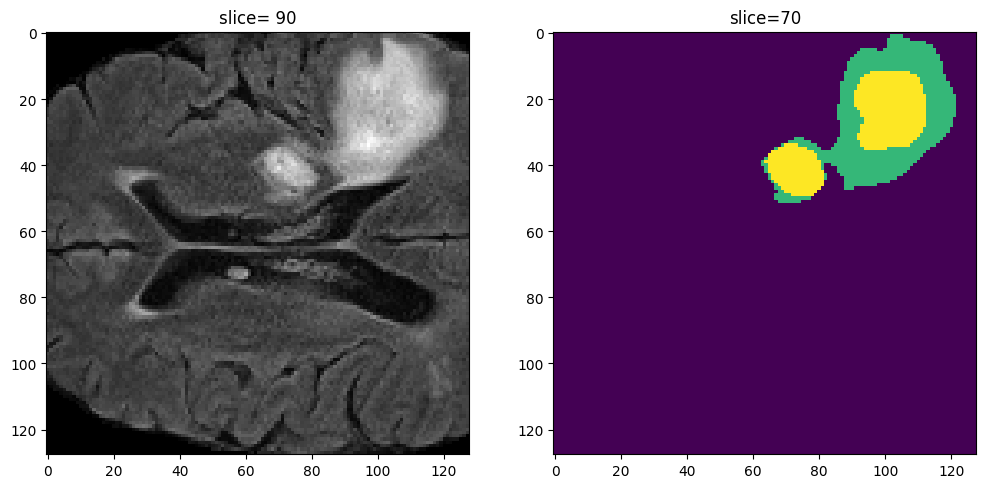

In [56]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('slice= 90')
plt.imshow(my_img[:,:,67,0], cmap='gray')
plt.subplot(122)
plt.title('slice=70')
plt.imshow(my_mask[:,:,67])